# Tweets dos possíveis candidatos a presidência em 2022
## Neste estudo queremos determinar qual é a relação entre os possíveis candidatos a presidência para 2022 atraves dos seus tweets publicados. Vamos fazer uma análise destes tweets e treinar um modelo que irá predizer a qual candidato determinado texto pertence.

# Bibliotecas Utilizadas e inicialização

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import squarify
import regex as re

from collections import Counter
from wordcloud import WordCloud
from datetime import datetime, time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

nlp = spacy.load("pt_core_news_md")


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [55]:
# stopwords e simbolos a retirar
stop_words_portugues = set(stopwords.words('portuguese'))
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '|', ' ', 'ser', 'vai', 'pra', 'q', 'p', 'tb', 'vou', 'ter', 'co'])   

In [8]:
print ("Início Execução : ")
print (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Início Execução : 
2021-04-25 17:49:46


# Funções Auxiliares

In [9]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [49]:
def print_topic_words(model, feature_names, n_top_words, topics):
    for index, topic in enumerate(model.components_):
        if (index in topics):
            message = "\nTópico #{}:".format(index)
            message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
            print(message)
            print("="*70)

In [41]:
def topico_politico(df, topicos):
    for i in topicos:
        print("\nTópico #{}:".format(i))
        print(df[df["Topico"]==i].groupby(["nome"]).size().sort_values(ascending=False)[:5])

In [56]:
def tweet_tokenizer(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    tweet = text.lower()
    tweet_token = [w for w in tokenize(tweet) if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbols)]
    tweet_token = [w for w in tweet_token if re.match(r'http*', w) == None]
    tweet_token = [w for w in tweet_token if emoji_pattern.match(w) == None]
    tweet_token = [w for w in tweet_token if not (w.startswith('@') | w.startswith('#') | w.startswith('\r'))]
    tweet_token = [w for w in tweet_token if w != 'rt']
        
    return " ".join(tweet_token)

In [12]:
def tokenize(texto):
    doc = nlp.tokenizer(texto)
    return [token.lower_ for token in doc if not (token.is_punct | token.is_stop)]

In [13]:
def unnest_tokens(df, # Data Frame (em linhas)
                  coluna_tokenize, # nome da coluna com os textos (tweets)
                  coluna_token_nome='palavra', # nome da coluna com os tokens
                  tokenizer_function=tokenize): # what tokenizer to use
    
    return (df[coluna_tokenize]
              .apply(tokenizer_function)
              .apply(pd.Series)
              .stack()
              .reset_index(level=0)
              .set_index('level_0')
              .rename(columns={0: coluna_token_nome})
              .join(df.drop(coluna_tokenize, 1), how='left')
              .reset_index(drop=True))

In [14]:
def retirando_palavras_indesejadas(df, coluna_token="palavra"):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df = df[~ df[coluna_token].isin(stop_words_ingles | stop_words_espanhol | symbols)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if re.match(r'http*', w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if emoji_pattern.match(w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if (w.startswith('@') | w.startswith('#') | w.startswith('\r') | w.startswith('.')))]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if w == 'rt')]
    return df

In [42]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

In [43]:
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Carregando os dados 

Os dados foram conseguidos via a API.V2 do tweeter diretamente do Banco de Dados do tweeter. Utilizamos a versão 2 desta API que permite um máximo de 3200 tweets por conta. Portanto a nossa análise vai estar limitada a este número máximo de mensagens o que em alguns casos cobre todos os tweets do político e em outras apenas o último ano.

Utilizamos esta API através do site WORKBENCH - https://app.workbenchdata.com/workflows/142512/

In [15]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
cols = ['nome'] + [col for col in df_politicos if col != 'nome']
df_politicos = df_politicos[cols]
df_politicos.reset_index(inplace=True)

In [16]:
df_politicos.head(10)

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   
5      5  Amoedo  2021-04-19T12:19:42Z   
6      6  Amoedo  2021-04-18T19:21:07Z   
7      7  Amoedo  2021-04-18T19:21:06Z   
8      8  Amoedo  2021-04-18T15:42:35Z   
9      9  Amoedo  2021-04-18T15:42:25Z   

                                                text                   id  
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735  
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259  
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825  
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517  
4                     Informações de @OGloboPolitica  1384121090243383296  
5  A CPI da Pandemia no Senado deve investigar o ...  1384119514418216969  
6  Leia a coluna completa em https://t.co/rvNDUpnqgA  1383863178853969921  
7  "Membros do Executivo e do Legislativo não ace...  1383863176891015168  
8                       Informações de @RevistaEpoca  1383808183223734272  
9  O governo federal gastará R$500 mil em uma cam...  1383808141897342986

In [17]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31633 entries, 0 to 31632
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       31633 non-null  int64 
 1   nome        31633 non-null  object
 2   created_at  31633 non-null  object
 3   text        31633 non-null  object
 4   id          31633 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


# WordClouds e outras análises

In [18]:
# criando dataframe apenas com as palavras e os politicos e o índice original para o tweet.
# já estamos retirando pontuações e STOP WORDS da lingua portuguesa.
#df_palavras = unnest_tokens(df_politicos.drop(['index','created_at','id'], axis=1), 'text')
df_palavras = unnest_tokens(df_politicos.drop(['created_at','id'], axis=1), 'text')

In [19]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512565 entries, 0 to 512564
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  512565 non-null  object
 1   index    512565 non-null  int64 
 2   nome     512565 non-null  object
dtypes: int64(1), object(2)
memory usage: 11.7+ MB


In [20]:
df_palavras = retirando_palavras_indesejadas(df_palavras)

In [21]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428774 entries, 2 to 512564
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  428774 non-null  object
 1   index    428774 non-null  int64 
 2   nome     428774 non-null  object
dtypes: int64(1), object(2)
memory usage: 13.1+ MB


In [22]:
df_palavras.head(50)

palavra  index    nome
2     presidente      0  Amoedo
3      americano      0  Amoedo
4            joe      0  Amoedo
5          biden      0  Amoedo
6        anuncia      0  Amoedo
7           hoje      0  Amoedo
8         vacina      0  Amoedo
9     disponível      0  Amoedo
10    americanos      0  Amoedo
12       podemos      1  Amoedo
13        deixar      1  Amoedo
14        brasil      1  Amoedo
15     continuar      1  Amoedo
16       andando      1  Amoedo
17          trás      1  Amoedo
21       governo      2  Amoedo
22       federal      2  Amoedo
23     congresso      2  Amoedo
24     ignoraram      2  Amoedo
25     orçamento      2  Amoedo
26          2021      2  Amoedo
27          onda      2  Amoedo
28   coronavírus      2  Amoedo
29  planejamento      2  Amoedo
30         levou      2  Amoedo
31       atrasos      2  Amoedo
33      -auxílio      2  Amoedo
34   emergencial      2  Amoedo
36     -programa      2  Amoedo
37    manutenção      2  Amoedo
38       emprego      2  Amoedo
40     -pronampe      2  Amoedo
42    brasileiro      2  Amoedo
43          paga      2  Amoedo
44         conta      2  Amoedo
45          fome      2  Amoedo
46    desemprego      2  Amoedo
47     falências      2  Amoedo
51       sugeriu      3  Amoedo
52       twitter      3  Amoedo
53         temas      3  Amoedo
54         serem      3  Amoedo
55  investigados      3  Amoedo
56           cpi      3  Amoedo
57         covid      3  Amoedo
59   informações      4  Amoedo
61           cpi      5  Amoedo
62      pandemia      5  Amoedo
63        senado      5  Amoedo
64    investigar      5  Amoedo

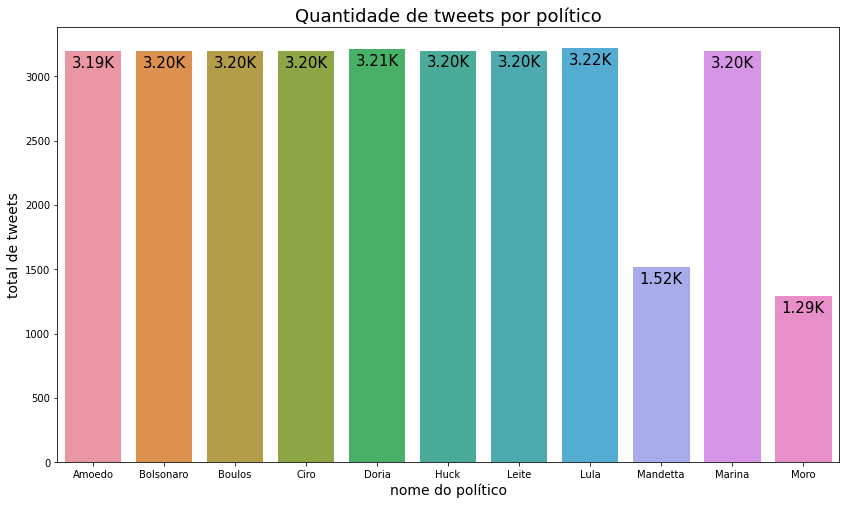

In [23]:
#quantidade de tweets por político

df_plot = df_politicos.groupby('nome').agg(total =('text','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de tweets", size=14)
plt.title("Quantidade de tweets por político", size=18)
for p in splot.patches:
    splot.annotate(format((p.get_height()/1000), '.2f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

### Conforme informamos no começo da análise o número de tweets está limitado em 3200. Verificamos que os candidatos Mandetta e Moro não possuem este número minimo. Buscando nas datas vemos que os dois, mesmo possuindo conta a menos tempo que os outros, publicam menos em um mesmo período.

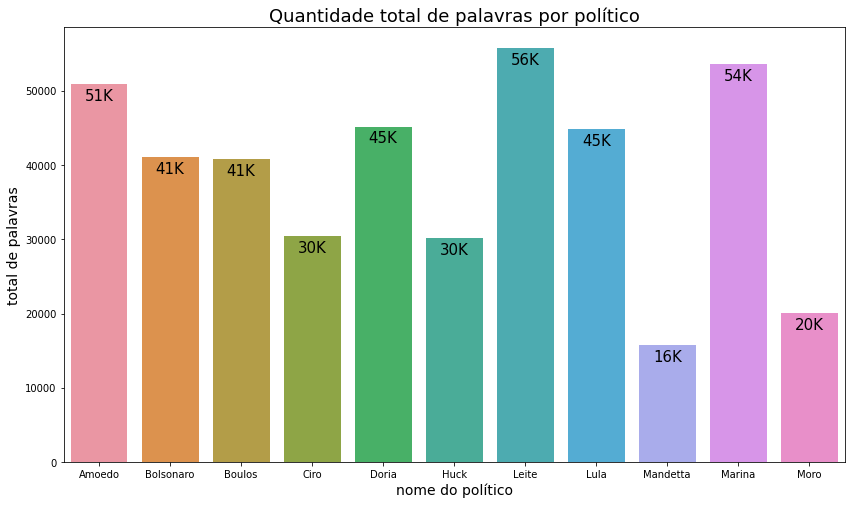

In [24]:
# quantidade de palavras por político

df_plot = df_palavras.groupby('nome').agg(total =('palavra','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de palavras por político", size=18)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()/1000), '.0f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

### Notamos que os possíveis candidatos Mandetta a Moro possuem menos palavras por terem menos tweets. Mas mesmo entre os com número igual de tweets percebemo que Ciro e Huck devem usar mais palavras de ligação (Stop Words) ou compratilhar links, pois seus números são bem menores que os demais.

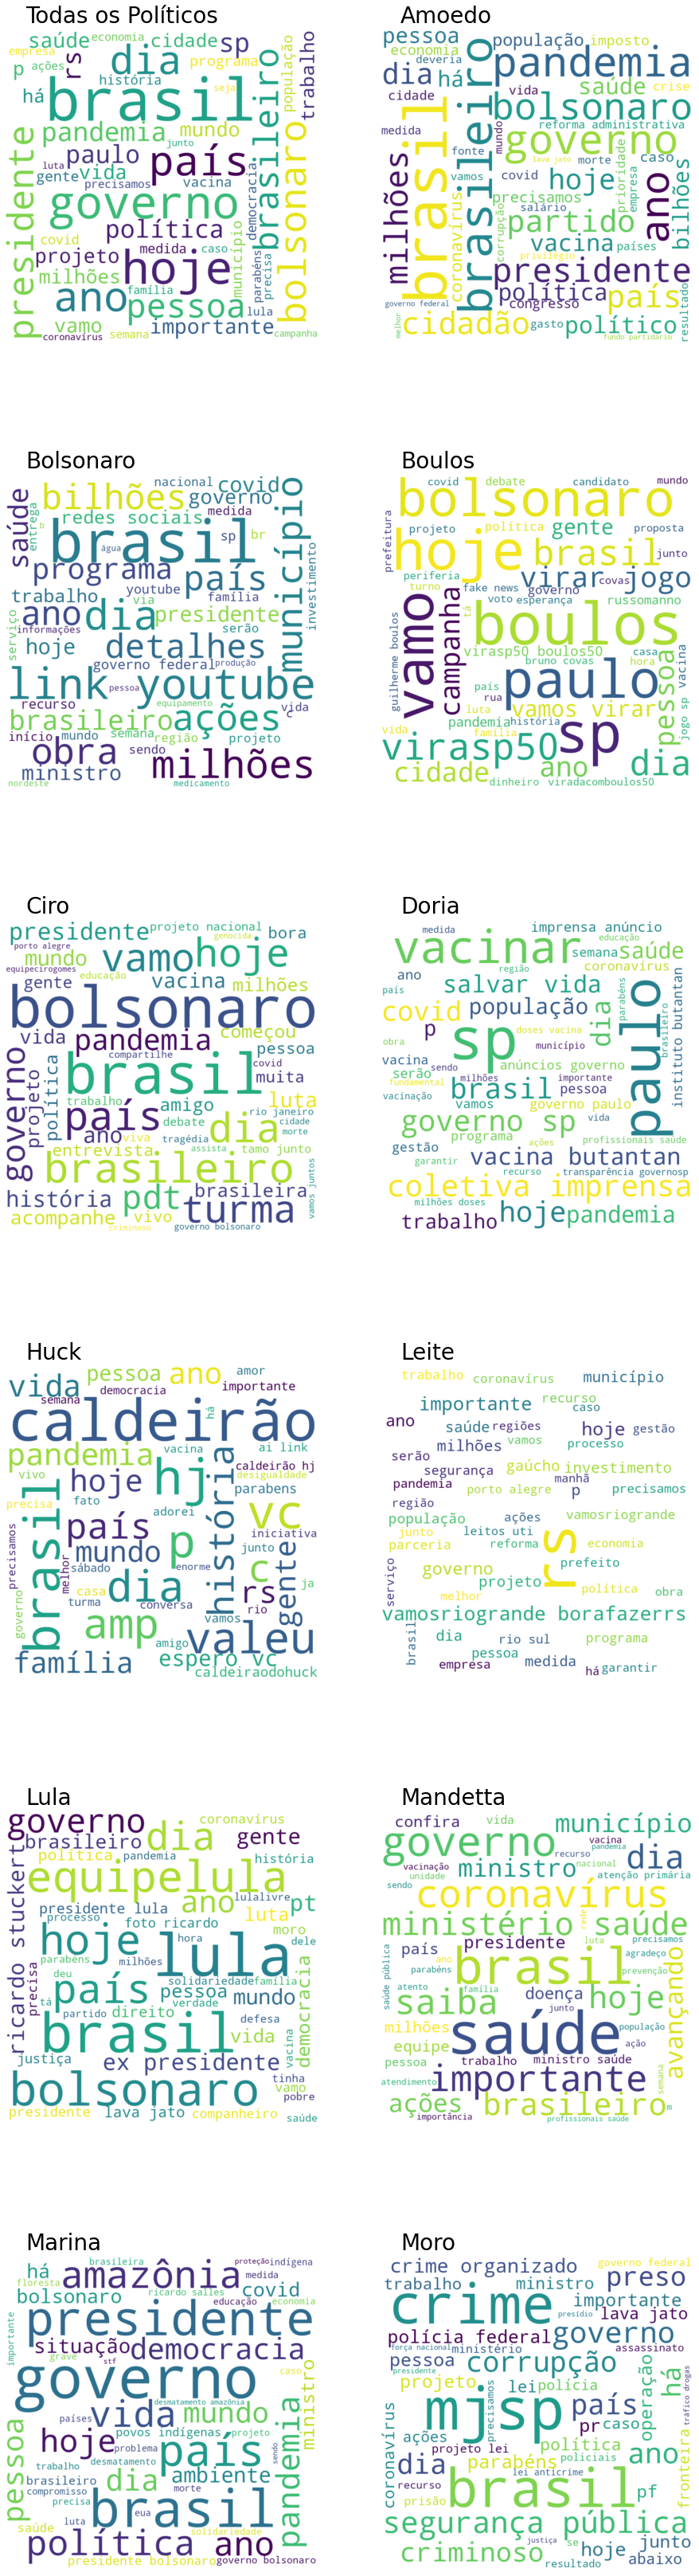

In [25]:
# wordcloud por político
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='w')
xc = 0
yc = 1
sumario = " ".join(s for s in df_palavras['palavra'])
wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, background_color='white').generate(sumario)
ax[0][0].imshow(wordcloud, interpolation="bilinear")
ax[0][0].text(50, -20, 'Todas os Políticos', fontsize=28, color='k')
ax[0][0].axis('off')

for idx in range(11):
    sumario = " ".join(s for s in df_palavras['palavra'][df_palavras['nome'] == nome_politicos[idx]])
    wordcloud = WordCloud(width=800, height=800, max_words=50, max_font_size=150, 
            background_color='white').generate(sumario)      
    ax[xc][yc].imshow(wordcloud, interpolation="bilinear")
    ax[xc][yc].text(50, -20, nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.subplots_adjust(right=0.8, left=0.2, wspace=0.2, hspace=0.2) 
plt.show()

## Temos uma grande variadade de palavras utilizadas por nosso possíveis candidatos. Apenas o Brasil e Bolsonaro se destacam em quase todos.

# Análise de frequências

In [26]:
# montando dataframe de frequências

c = Counter(df_palavras['palavra']).most_common()
df_palavras_qtd = pd.DataFrame(c, columns=['palavra', 'qtd'])
for politico in nome_politicos:
    c = Counter(df_palavras['palavra'][df_palavras['nome'] == politico]).most_common()
    d = pd.DataFrame(c, columns=['palavra', politico])
    #d[f'f-{politico}'] = d[politico] / df_palavras_qtd['qtd']
    df_palavras_qtd = pd.merge(df_palavras_qtd, d, on='palavra')

In [27]:
#df_palavras_qtd[df_palavras_qtd['palavra'] == " "]
df_palavras_qtd[:20]

palavra   qtd  Amoedo  Bolsonaro  Boulos  Ciro  Doria  Huck  Leite  \
0        brasil  3492     529        406     211   461    248   226    100   
1       governo  2907     292        240     160   213    470    35    284   
2          hoje  2275     142        116     284   237    319   125    423   
3         saúde  2040     212        152     121   149    337    88    227   
4     bolsonaro  2032     276         77     285   618     39     1      6   
5           dia  1696      87        150     172   194    221   222    141   
6          país  1616     226        137      91   190     70   113     54   
7       milhões  1597     221        279      97   108    278    26    303   
8    presidente  1593     233        167      44    97     68    21     83   
9            sp  1447      33         88     371    11    857    20     17   
10     pandemia  1429     235         54     146   103    284   106    165   
11        vamos  1401     114         20     467   306    130    65    105   
12        paulo  1304      51         46     366    56    577    27     38   
13         anos  1211     150         90     146    74    119    88    142   
14      pessoas  1197     119         85     180    52    139    72    147   
15  coronavírus  1165     172         46      13    24    309    12    199   
16         vida  1148      98         49      81    79    212    99    103   
17    população   945     120         59      61    25    286    21    182   
18           rs   933       4         62      11     7      2   103    731   
19       vacina   879     121         51      82    57    397    32     22   

    Lula  Mandetta  Marina  Moro  
0    483       197     488   143  
1    215       153     715   130  
2    290        70     208    61  
3    104       445     186    19  
4    361        17     340    12  
5    201        90     156    62  
6    246        55     346    88  
7     98        52     116    19  
8    264        55     524    37  
9     22         5      14     9  
10    78        25     214    19  
11    92        31      40    31  
12    76        10      39    18  
13   212        29     114    47  
14   126        40     178    59  
15   103       141      87    59  
16   134        41     238    14  
17    35        57      78    21  
18     2         1       2     8  
19    59        22      30     6

In [28]:
df_palavras_freq = df_palavras_qtd.copy()
for politico in nome_politicos:
     df_palavras_freq[politico] =  df_palavras_qtd[politico]/df_palavras_qtd['qtd']

df_palavras_freq[:20]

palavra   qtd    Amoedo  Bolsonaro    Boulos      Ciro     Doria  \
0        brasil  3492  0.151489   0.116266  0.060424  0.132016  0.071019   
1       governo  2907  0.100447   0.082559  0.055040  0.073271  0.161679   
2          hoje  2275  0.062418   0.050989  0.124835  0.104176  0.140220   
3         saúde  2040  0.103922   0.074510  0.059314  0.073039  0.165196   
4     bolsonaro  2032  0.135827   0.037894  0.140256  0.304134  0.019193   
5           dia  1696  0.051297   0.088443  0.101415  0.114387  0.130307   
6          país  1616  0.139851   0.084777  0.056312  0.117574  0.043317   
7       milhões  1597  0.138384   0.174703  0.060739  0.067627  0.174076   
8    presidente  1593  0.146265   0.104834  0.027621  0.060891  0.042687   
9            sp  1447  0.022806   0.060815  0.256393  0.007602  0.592260   
10     pandemia  1429  0.164451   0.037789  0.102169  0.072078  0.198740   
11        vamos  1401  0.081370   0.014276  0.333333  0.218415  0.092791   
12        paulo  1304  0.039110   0.035276  0.280675  0.042945  0.442485   
13         anos  1211  0.123865   0.074319  0.120562  0.061107  0.098266   
14      pessoas  1197  0.099415   0.071011  0.150376  0.043442  0.116124   
15  coronavírus  1165  0.147639   0.039485  0.011159  0.020601  0.265236   
16         vida  1148  0.085366   0.042683  0.070557  0.068815  0.184669   
17    população   945  0.126984   0.062434  0.064550  0.026455  0.302646   
18           rs   933  0.004287   0.066452  0.011790  0.007503  0.002144   
19       vacina   879  0.137656   0.058020  0.093288  0.064846  0.451650   

        Huck     Leite      Lula  Mandetta    Marina      Moro  
0   0.064719  0.028637  0.138316  0.056415  0.139748  0.040951  
1   0.012040  0.097695  0.073959  0.052632  0.245958  0.044720  
2   0.054945  0.185934  0.127473  0.030769  0.091429  0.026813  
3   0.043137  0.111275  0.050980  0.218137  0.091176  0.009314  
4   0.000492  0.002953  0.177657  0.008366  0.167323  0.005906  
5   0.130896  0.083137  0.118514  0.053066  0.091981  0.036557  
6   0.069926  0.033416  0.152228  0.034035  0.214109  0.054455  
7   0.016281  0.189731  0.061365  0.032561  0.072636  0.011897  
8   0.013183  0.052103  0.165725  0.034526  0.328939  0.023227  
9   0.013822  0.011748  0.015204  0.003455  0.009675  0.006220  
10  0.074178  0.115465  0.054584  0.017495  0.149755  0.013296  
11  0.046395  0.074946  0.065667  0.022127  0.028551  0.022127  
12  0.020706  0.029141  0.058282  0.007669  0.029908  0.013804  
13  0.072667  0.117258  0.175062  0.023947  0.094137  0.038811  
14  0.060150  0.122807  0.105263  0.033417  0.148705  0.049290  
15  0.010300  0.170815  0.088412  0.121030  0.074678  0.050644  
16  0.086237  0.089721  0.116725  0.035714  0.207317  0.012195  
17  0.022222  0.192593  0.037037  0.060317  0.082540  0.022222  
18  0.110397  0.783494  0.002144  0.001072  0.002144  0.008574  
19  0.036405  0.025028  0.067122  0.025028  0.034130  0.006826

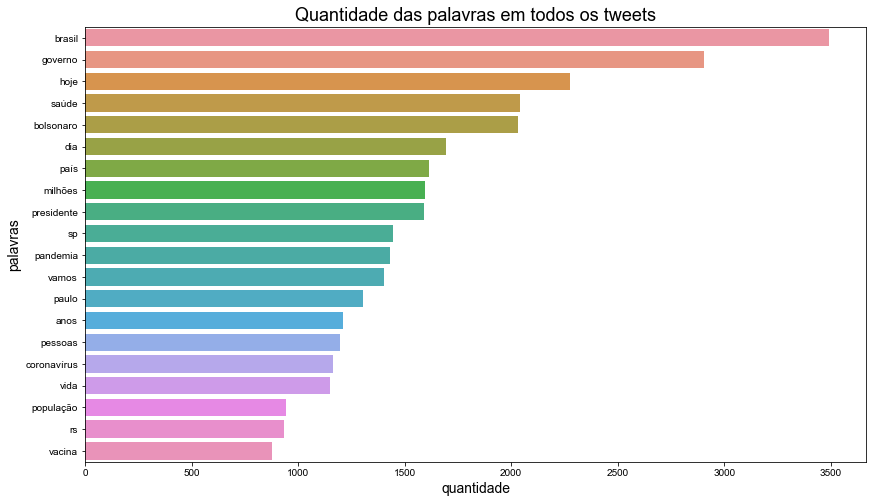

In [29]:
# quantidade de palavras
df_plot = df_palavras_freq[:20]

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="qtd", y="palavra", data=df_plot)
sns.set_style("darkgrid")
plt.xlabel("quantidade", size=14)
plt.ylabel("palavras", size=14)
plt.title("Quantidade das palavras em todos os tweets", size=18)

plt.show()

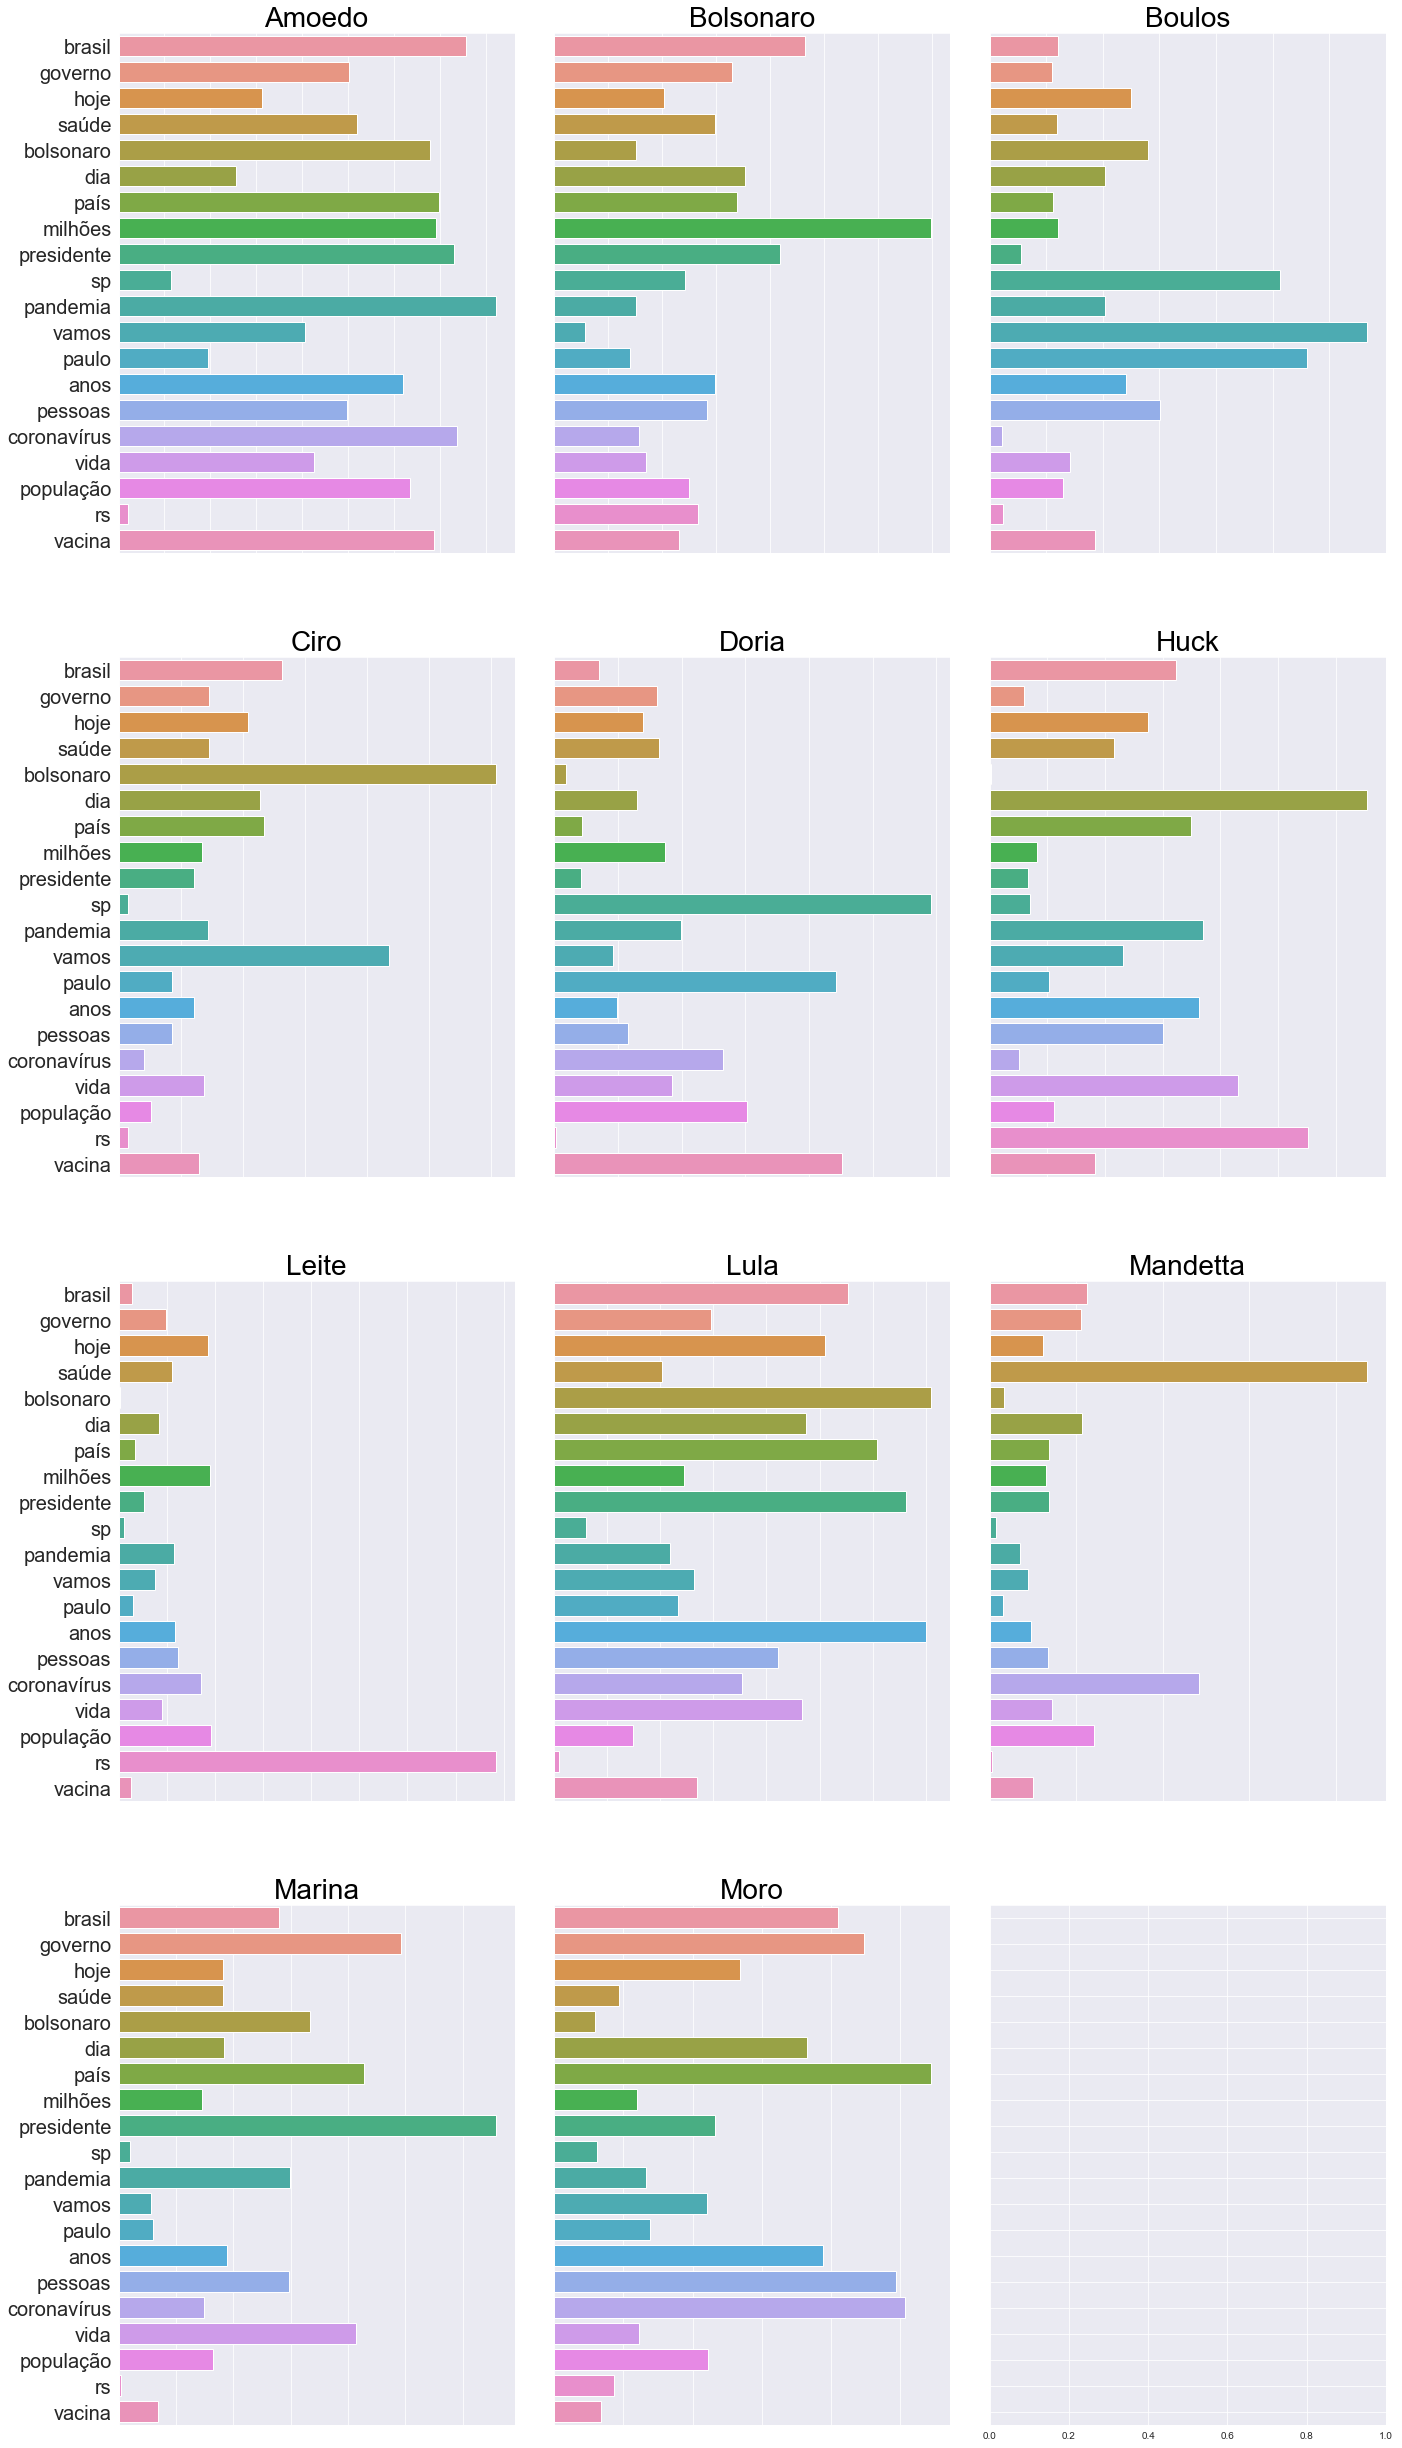

In [30]:
colors = [f'C{x}' for x in range(11)]
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(22, 44), facecolor='w', sharey=True)
xc=0
yc=0
for idx in range(11):
    sns.barplot(y=df_plot['palavra'], x=df_plot[nome_politicos[idx]], ax=ax[xc][yc])
    #ax[xc][yc].barh(y=df_plot['palavra'], width=df_plot[nome_politicos[idx]], height=0.5, color=colors)
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].set_ylabel('')
    ax[xc][yc].set_xlabel('')
    ax[xc][yc].tick_params(axis='y', labelsize=20)
    ax[xc][yc].tick_params(axis='x', labelcolor='white')
    yc += 1
    if (yc == 3):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.subplots_adjust(right=0.9, left=0.1, wspace=0.1)
plt.show()

## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos

Alocação Latente de Dirichlet é um modelo estatístico generativo que permite que conjuntos de observações sejam explicados por grupos não observados que explicam o porquê algumas partes dos dados são semelhantes.

In [57]:
# Tokenizando cada tweet dos candidatos
df_politicos['tweet_token'] = df_politicos['text'].apply(tweet_tokenizer)
df_politicos.head()

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   

                                                text                   id  \
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735   
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259   
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825   
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517   
4                     Informações de @OGloboPolitica  1384121090243383296   

                                         tweet_token  Topico  
0  presidente americano joe biden anuncia hoje va...       4  
1       podemos deixar brasil continuar andando trás      20  
2  governo federal congresso ignoraram orçamento ...      21  
3  .@joaoamoedonovo sugeriu twitter temas serem i...       6  
4                                        informações      19

In [58]:
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(list(df_politicos['tweet_token']))

## Grid Search (Hyper Parameter Tunning)

Hyper Parameter Tunning, realizamos Grid Search para encontrar o melhor modelo de LDA, configuramos os hiperparâmetros 'n_components' e 'learning_decay'

In [59]:
# Define Search Param
#search_params = {'n_components':[22, 33, 44, 55, 66], 'learning_decay': [.3, .5, .7, .9, 1]}

# Init the Model
#lda = LatentDirichletAllocation()

# Init Grid Search Class
#model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
#model.fit(tf)

In [60]:
# Melhor modelo
#lda = model.best_estimator_

# Hiperparâmetros do modelo
#print("Melhores parâmetros: ", model.best_params_)

# probabilidade logarítmica
#print("Melhor score de probabilidade logarítmica: ", model.best_score_)

# Perplexidade
#print("Perplexidade do modelo: ", lda.perplexity(tf))

In [61]:
#results = pd.DataFrame(model.cv_results_)

#current_palette = sns.color_palette("Set2", 5)
#plt.figure(figsize=(12,8))
#sns.lineplot(data=results,
#             x='param_n_components',
#             y='mean_test_score',
#             hue='param_learning_decay',
#             palette=current_palette,
#             marker='o'
#            )

#plt.show()

## Treinando Modelo LDA

In [62]:
#Criando o Modelo e treinando
lda = LatentDirichletAllocation(n_components=22,
                                learning_decay = 0.5,
                                random_state = 30)
lda_output = lda.fit_transform(tf)

In [63]:
# Probabilidade logaritmica: quanto maior melhor
print("probabilidade logaritmica: ", round(lda.score(tf), 2))

# Perplexidade: menor melhor.  exp(-1. * log-Probabilidade logaritmica por palavra)
print("Perplexidade: ", round(lda.perplexity(tf), 2))

print("Parâmetros:")
print(lda.get_params())

probabilidade logaritmica:  -3882982.48
Perplexidade:  9626.52
Parâmetros:
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.5, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 22, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 30, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


## Classificando o Tópico dominante para cada Tweet

In [64]:
# column names
topicnames = ["Topic" + str(i+1) for i in range(lda.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_politicos))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics_first10 = df_document_topic[:10].style.applymap(color_green).applymap(make_bold)
df_document_topics_first10

In [65]:
# Encontrado os 5 tópicos mais mencionados pelos Tweets
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.head(5)

Topic Num  Num Documents
0          0           2905
1          3           2492
2         19           2075
3         11           2055
4          5           1938

## Tópicos mais encontrados

In [66]:
# Exibindo 10 primeiras palavras que identificam os 5 primeiros tópicos
top_topics = df_topic_distribution['Topic Num'][:5].tolist()
n_top_words = 10
print("\nTop 5 Tópicos do Modelo LDA: ")
print("*"*70)
tf_feature_names = tf_vectorizer.get_feature_names()
print_topic_words(lda, tf_feature_names, n_top_words, top_topics)


Top 5 Tópicos do Modelo LDA: 
**********************************************************************

Tópico #0:caldeirão, hj, valeu, vcs, espero, abraço, amp, porto, forte, alegre

Tópico #3:saúde, vacina, covid, 19, milhões, brasil, coronavírus, vidas, vacinação, vacinas

Tópico #5:luta, brasil, dia, juntos, feliz, vida, parabéns, amigo, história, hoje

Tópico #11:bolsonaro, presidente, brasil, governo, país, democracia, precisa, stf, pandemia, justiça

Tópico #19:empresas, rs, empregos, investimentos, governo, serviços, desenvolvimento, renda, educação, setor


* Tópico 1 - Obras e Infraestrutura
* Tópico 6 - Reforma e Desenvolvimento
* Tópico 7 - Imprensa
* Tópico 15 - Caldeirão, espero e história
* Tópico 21 - Gratidão

In [67]:
# Identificando o Tópico dominante para cada tweet coletado
df2 = pd.DataFrame(data=df_document_topics.data, columns=df_document_topics.columns)
df_politicos["Topico"] = df2["dominant_topic"].tolist()
df_politicos.head()

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   

                                                text                   id  \
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735   
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259   
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825   
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517   
4                     Informações de @OGloboPolitica  1384121090243383296   

                                         tweet_token  Topico  
0  presidente americano joe biden anuncia hoje va...      10  
1       podemos deixar brasil continuar andando trás      11  
2  governo federal congresso ignoraram orçamento ...      12  
3  .@joaoamoedonovo sugeriu twitter temas serem i...       2  
4                                        informações      16

In [52]:
#Identificando Políticos por tópico dominante
df_politicos.groupby(["Topico"])['nome'].agg(pd.Series.mode).to_frame()

nome
Topico           
0       Bolsonaro
1          Amoedo
2            Ciro
3          Boulos
4          Amoedo
5       Bolsonaro
6            Lula
7            Huck
8          Boulos
9           Doria
10           Ciro
11           Ciro
12         Marina
13           Lula
14          Leite
15          Doria
16          Leite
17      Bolsonaro
18      Bolsonaro
19          Doria
20         Marina
21         Amoedo

In [68]:
# Politicos dos 5 primeiros Tópicos
topico_politico(df_politicos, top_topics)


Tópico #0:
nome
Huck         971
Bolsonaro    559
Ciro         391
Mandetta     337
Lula         141
dtype: int64

Tópico #3:
nome
Doria        743
Bolsonaro    319
Mandetta     301
Leite        253
Amoedo       249
dtype: int64

Tópico #19:
nome
Leite        641
Amoedo       436
Doria        327
Bolsonaro    159
Boulos       113
dtype: int64

Tópico #11:
nome
Marina    582
Amoedo    387
Lula      339
Ciro      213
Boulos    124
dtype: int64

Tópico #5:
nome
Huck      509
Ciro      468
Lula      304
Marina    141
Boulos    120
dtype: int64


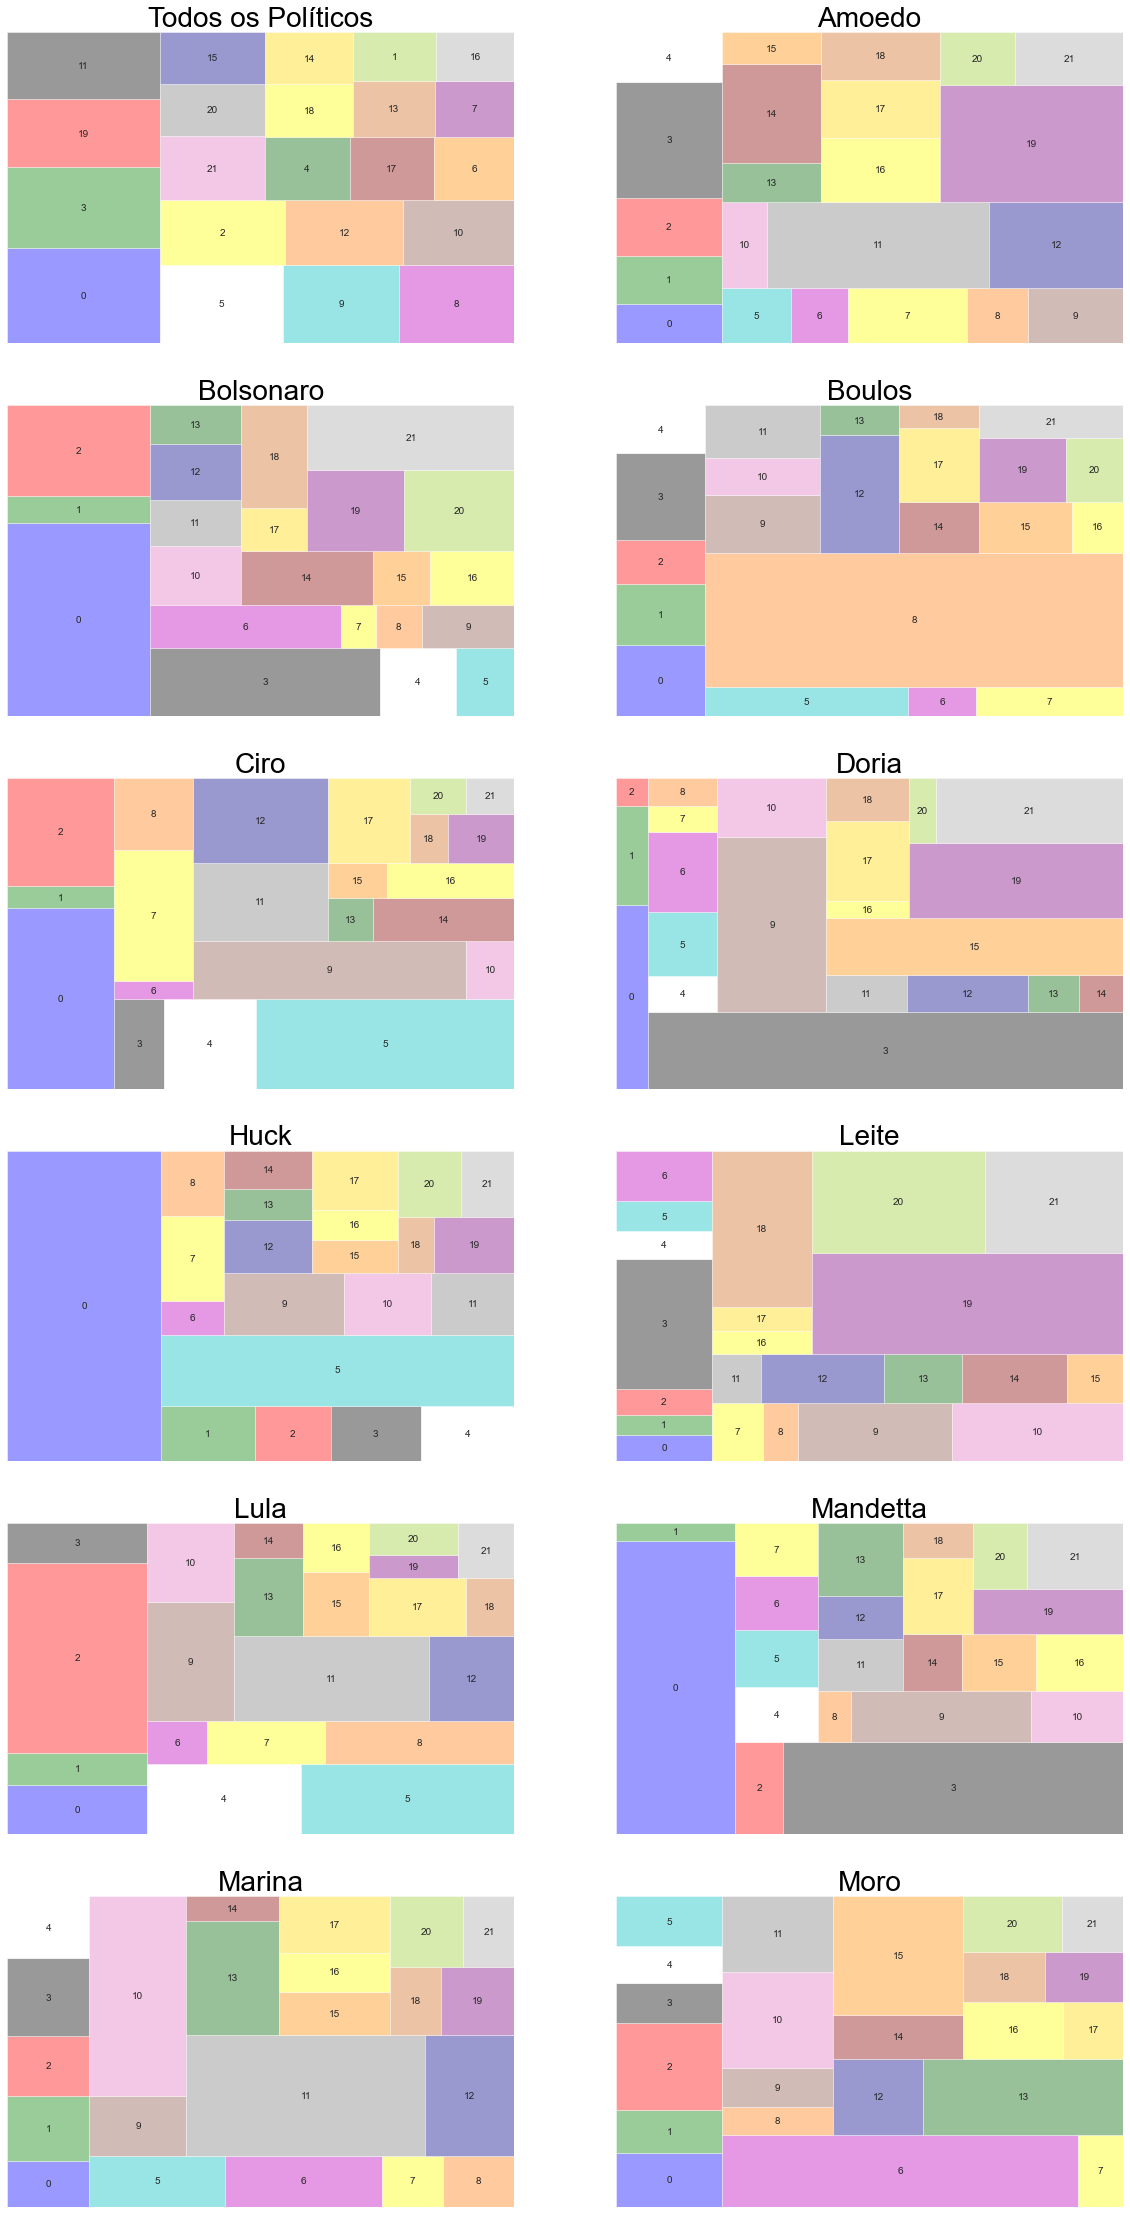

In [69]:
# treemap por politico
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 40), facecolor='w')
# Cores para cada tópico
colors = ['b', 'g', 'r', 'k', 'w', 'c', 'm', 'yellow', 'tab:orange', 'tab:brown', 'tab:pink', 
                     'tab:gray', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'yellow', 'gold', 'chocolate',
                     'purple', 'yellowgreen', 'darkgrey']
xc = 0
yc = 1
# Treemap contagem de tópicos Geral
squarify.plot(sizes=df_topic_distribution['Num Documents'], ax=ax[0][0], label=df_topic_distribution['Topic Num'], alpha=.4, color=colors)
ax[0][0].set_title('Todos os Políticos', fontsize=28, color='black')
ax[0][0].axis('off')

# Itera a lista de politicos para gerar Treemap de cada politico com seus tópicos
for idx in range(11):
    dfTopicos = df_politicos[df_politicos["nome"]==nome_politicos[idx]].groupby(["Topico"]).size().to_frame().reset_index("Topico")
    dfTopicos.columns = ['Topico', 'Quantidade']
    squarify.plot(sizes=dfTopicos['Quantidade'], ax=ax[xc][yc], label=dfTopicos['Topico'], alpha=.4, color=colors)
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc >= 2):
        yc = 0
        xc += 1
        if (xc >= 6):
            xc = 0   

plt.show()

## Comparar Bolsonaro x Ciro x Doria x Lula

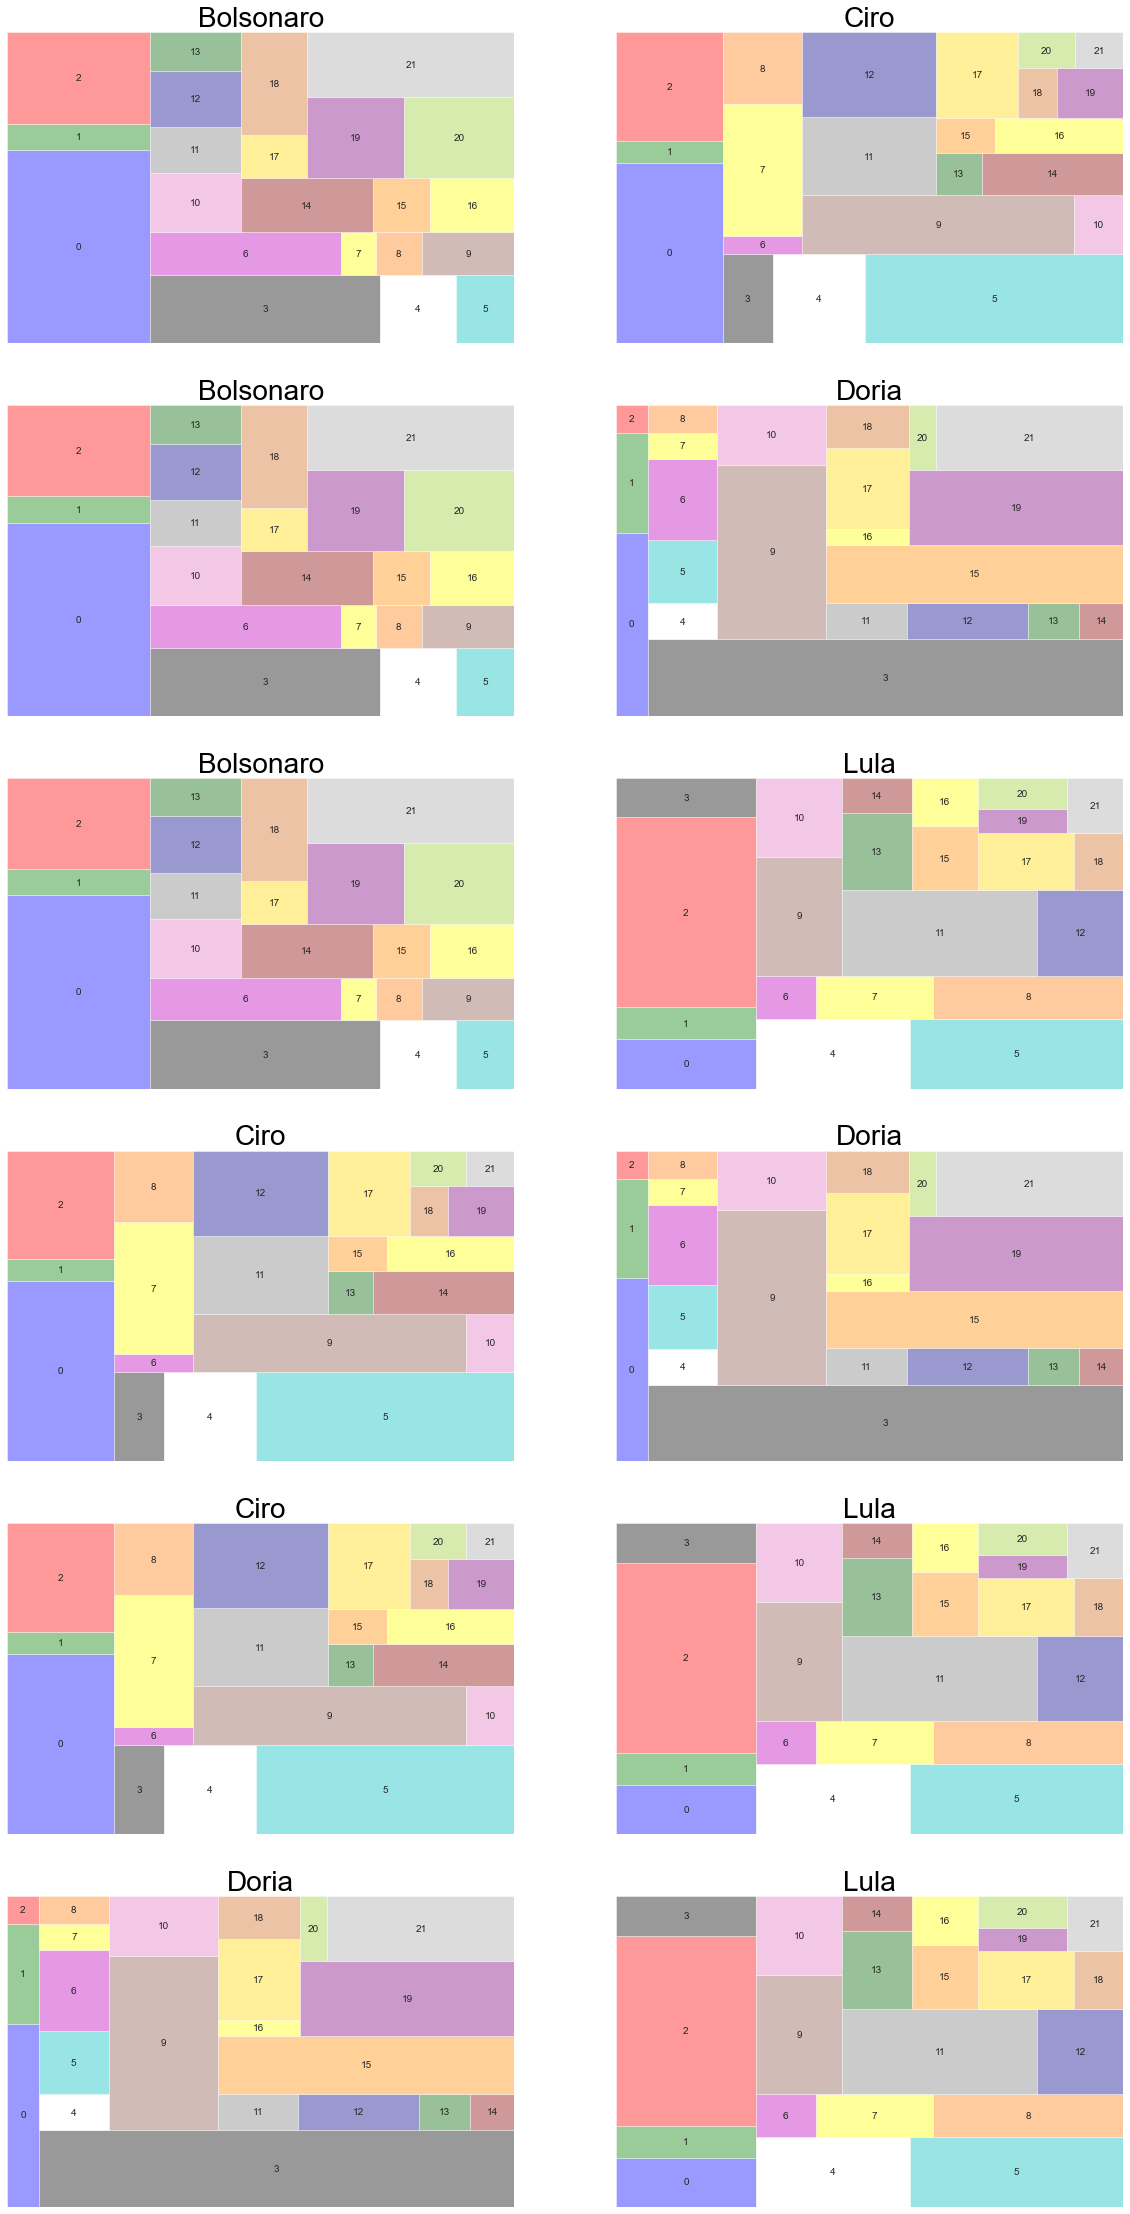

In [70]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 40), facecolor='w')

dfBolsonaro = df_politicos[df_politicos["nome"]=='Bolsonaro'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfBolsonaro.columns = ['Topico', 'Quantidade']

dfCiro = df_politicos[df_politicos["nome"]=='Ciro'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfCiro.columns = ['Topico', 'Quantidade']

dfDoria = df_politicos[df_politicos["nome"]=='Doria'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfDoria.columns = ['Topico', 'Quantidade']

dfLula = df_politicos[df_politicos["nome"]=='Lula'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfLula.columns = ['Topico', 'Quantidade']

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[0][0])
ax[0][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[0][0].axis('off')

squarify.plot(sizes=dfCiro['Quantidade'], label=dfCiro['Topico'], color=colors, alpha=.4, ax=ax[0][1])
ax[0][1].set_title('Ciro', fontsize=28, color='black')
ax[0][1].axis('off')

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[1][0])
ax[1][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[1][0].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[1][1])
ax[1][1].set_title('Doria', fontsize=28, color='black')
ax[1][1].axis('off')

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[2][0])
ax[2][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[2][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[2][1])
ax[2][1].set_title('Lula', fontsize=28, color='black')
ax[2][1].axis('off')

squarify.plot(sizes=dfCiro['Quantidade'], label=dfCiro['Topico'], color=colors, alpha=.4, ax=ax[3][0])
ax[3][0].set_title('Ciro', fontsize=28, color='black')
ax[3][0].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[3][1])
ax[3][1].set_title('Doria', fontsize=28, color='black')
ax[3][1].axis('off')

squarify.plot(sizes=dfCiro['Quantidade'], label=dfCiro['Topico'], color=colors, alpha=.4, ax=ax[4][0])
ax[4][0].set_title('Ciro', fontsize=28, color='black')
ax[4][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[4][1])
ax[4][1].set_title('Lula', fontsize=28, color='black')
ax[4][1].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[5][0])
ax[5][0].set_title('Doria', fontsize=28, color='black')
ax[5][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[5][1])
ax[5][1].set_title('Lula', fontsize=28, color='black')
ax[5][1].axis('off')

plt.show()

* Bolsonaro x Ciro - Tópico 1
* Bolsonaro x Doria - Tópico 6
* Bolsonaro x Lula - Tópico 22
* Ciro x Doria - Tópico 13
* Ciro x Lula - Tópicos 2, 3
* Doria x Lula - Tópicos 2, 3, 17, 18

## Representação Gráfica dos Tópicos

In [72]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds = 'pcoa')
dash

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.142791  0.028775       1        1  8.374307
19    -0.159909 -0.049003       2        1  7.660081
11     0.009809 -0.131646       3        1  6.922295
21    -0.142673  0.055249       4        1  5.484953
12    -0.068613 -0.080807       5        1  5.443773
10    -0.033302 -0.003494       6        1  5.317184
5      0.187793 -0.080538       7        1  4.826275
8      0.160992 -0.031741       8        1  4.774190
2      0.116112  0.149534       9        1  4.625323
9      0.081589  0.227948      10        1  4.359628
18    -0.126163  0.040083      11        1  4.143604
6     -0.087908  0.047765      12        1  4.103312
14    -0.064295 -0.014490      13        1  3.794056
20    -0.064207  0.028749      14        1  3.757316
15     0.018629  0.124370      15        1  3.638708
4      0.061407 -0.093575      16        1  3.596709
13    -0.027312 -0.035010      17        1  3.571629
17     0.029870 -0.060177      18        1  3.550855
0      0.190648  0.028593      19        1  3.241552
16    -0.053991 -0.041357      20        1  3.062167
1      0.009272 -0.023909      21        1  2.961532
7      0.105042 -0.085320      22        1  2.790550, topic_info=             Term         Freq        Total Category  logprob  loglift
22305        lula   904.000000   904.000000  Default  30.0000  30.0000
35395      vacina   822.000000   822.000000  Default  29.0000  29.0000
31840       saúde  1909.000000  1909.000000  Default  28.0000  28.0000
10042       covid  1029.000000  1029.000000  Default  27.0000  27.0000
5933    bolsonaro  1913.000000  1913.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
27701  precisamos    32.868032   495.457168  Topic22  -5.8845   0.8660
18579        hoje    37.769351  2083.244088  Topic22  -5.7455  -0.4313
28330    produção    28.066545   252.825930  Topic22  -6.0424   1.3808
10214       crise    26.806028   608.512821  Topic22  -6.0884   0.4565
26352        país    26.842588  1508.114084  Topic22  -6.0870  -0.4497

[1591 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
0          1  0.018162      00
0          3  0.027243      00
0          4  0.544863      00
0          5  0.099892      00
0          9  0.045405      00
...      ...       ...     ...
36907     11  0.017598  órgãos
36907     12  0.316768  órgãos
36907     13  0.017598  órgãos
36907     17  0.272772  órgãos
36907     18  0.043996  órgãos

[6286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 20, 12, 22, 13, 11, 6, 9, 3, 10, 19, 7, 15, 21, 16, 5, 14, 18, 1, 17, 2, 8])